In [41]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_array

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
folder = "database_cleaned"
avis_clean = pd.read_csv(f"database_cleaned/avis_clean.csv", index_col=0)
jeux_clean = pd.read_csv(f"database_cleaned/jeux_clean.csv", index_col=0)
users = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])

# Baseline cos. RMSE distribution based on `min_reviews`

In [27]:
min_reviews = np.arange(5, 13, 1)
users_games = []
nb_users = 300

In [28]:
vect_rmse = np.vectorize(calc_RMSE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
rmses = []
for lim in min_reviews:
    rev_filter = filter_df(avis_clean, lim)
    users_games.append((rev_filter["User id"].nunique(), rev_filter["Game id"].nunique()))
    matrix_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
    similarity_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
    users_count = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values(by="Game id", ascending=False).head(50)
    users = users_table_assoc[users_table_assoc.isin(users_count.index)].index.to_numpy()
    np.random.seed(1)
    result = vect_rmse(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)

    rmses.append(result)

11201 10549
3242 3957
3006 3910
3003 3910
11201 10549
2908 3516
2671 3481
2665 3480
11201 10549
2639 3210
2387 3157
2379 3156
11201 10549
2437 2911
2150 2853
2139 2846
11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614
11201 10549
2086 2464
1800 2399
1792 2397
1791 2396
11201 10549
1965 2282
1649 2196
1638 2191
1637 2191
11201 10549
1850 2107
1530 2021
1509 2011
1507 2011


In [30]:
rmses_means = np.array(rmses)
np.save("generated_data/rmses_violin_plot_cos_50_users.npy", np.array(rmses))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_9006/307442131.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(f"{ug}\n{lim}" for ug, lim in tuple(zip(users_games, min_reviews.astype(int))))


Text(0, 0.5, 'RMSE')

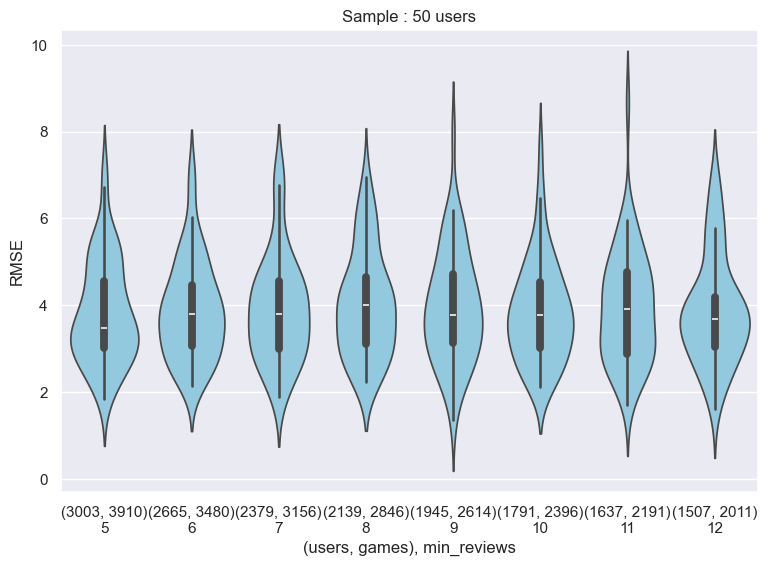

In [31]:
sns.set_theme(rc={'figure.figsize':(9,6)})

ax = sns.violinplot(list(rmses),  color="skyblue")
ax.set_title("Sample : 50 users")
ax.set_xticklabels(f"{ug}\n{lim}" for ug, lim in tuple(zip(users_games, min_reviews.astype(int))))

ax.set_xlabel("(users, games), min_reviews")
ax.set_ylabel("RMSE")

# Baseline euclidean, cos. RMSE distribution comparison
## 50 users most active users 
### [min = 272, max = 1337]



In [32]:
min_reviews = 5
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
3242 3957
3006 3910
3003 3910


In [34]:
matrix_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
k = int(np.sqrt(matrix_ratings.shape[0]))
k

54

In [35]:
#similarity_matrix_cos, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
similarity_matrix_eucl, mask_sim_eucl = calc_similarity_matrix(matrix_ratings, mask_ratings, "euclidean")


In [10]:
np.save("generated_data/eucl_sim_matrix_min5.npy", similarity_matrix_eucl.toarray())
np.save("generated_data/eucl_sim_mask_min5.npy", mask_sim_eucl.toarray())

In [ ]:
similarity_matrix_eucl, mask_sim_eucl = np.load("generated_data/eucl_sim_matrix_min5.npy"), np.load("generated_data/eucl_sim_mask_min5.npy")
# Non zero values
nonzeros = mask_sim_eucl.nonzero()

# Convert to sparse
similarity_matrix_eucl = csr_array((similarity_matrix_eucl[nonzeros], nonzeros))
mask_sim_eucl = csr_array((mask_sim_eucl[nonzeros], nonzeros))
similarity_matrix_eucl

<Compressed Sparse Row sparse array of dtype 'float64'
	with 2238677 stored elements and shape (3003, 3003)>

In [37]:
similarity_matrix_cos = np.load("generated_data/cos_sim_matrix_min5.npy")
similarity_matrix_cos

array([[0.        , 0.90631531, 0.84503229, ..., 1.        , 1.        ,
        0.98883848],
       [0.90631531, 0.        , 0.70944996, ..., 0.98849347, 1.        ,
        0.99491711],
       [0.84503229, 0.70944996, 0.        , ..., 1.        , 1.        ,
        0.98260143],
       ...,
       [1.        , 0.98849347, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.98883848, 0.99491711, 0.98260143, ..., 1.        , 1.        ,
        0.        ]], shape=(3003, 3003))

In [38]:
users_count = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values(by="Game id", ascending=False).head(50)
#users_count = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count()
#users_count = users_count[(users_count["Game id"] < 500) & (users_count["Game id"] > 200)].sample(50)

users = users_table_assoc[users_table_assoc.isin(users_count.index)].index.to_numpy()
users_count.columns = ["Count reviews"]
users_count

,Count reviews
User id,
208,1337
1,970
83,921
91,764
201,702
1724,654
1936,574
2,470
1998,452


In [39]:
np.random.seed(1)
vect_rmse_cos = np.vectorize(calc_RMSE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
rmse_cos = vect_rmse_cos(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix_cos)

In [13]:
rmse_cos

array([2.5962144 , 2.83270483, 1.75261101, 4.66672048, 3.19448683,
       2.84201336, 6.1899951 , 2.55131586, 4.85070227, 3.56188302,
       3.16920657, 2.43529151, 3.43288135, 5.29643724, 4.3691895 ,
       2.68107684, 4.6328517 , 3.65319537, 5.17965157, 5.22592191,
       2.48195359, 7.00177894, 3.52569027, 3.34730945, 6.89141425,
       2.22899225, 2.8566188 , 2.95092983, 5.98991889, 3.51479318,
       3.3298791 , 5.11355195, 3.55831921, 5.30852867, 2.88398237,
       2.94222862, 3.32344076, 5.87750017, 4.67861065, 4.356644  ,
       3.89815033, 4.37975139, 4.64417748, 3.01717334, 2.80526296,
       5.62421623, 2.80234992, 3.25631777, 3.74363344, 4.40877409])

In [40]:
np.random.seed(1)
vect_rmse_eucl = np.vectorize(calc_RMSE_eucl, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix', 'mask_sim_matrix'])
rmse_eucl = vect_rmse_eucl(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix_eucl, mask_sim_matrix=mask_sim_eucl)

AttributeError: 'numpy.ndarray' object has no attribute 'todok'

In [10]:
df_rmse_cos = pd.DataFrame(zip(users_table_assoc[users], rmse_cos), columns=["User id", "RMSE"]).merge(users_count, on ="User id").assign(dataset="cos")
df_rmse_eucl = pd.DataFrame(zip(users_table_assoc[users], rmse_eucl), columns=["User id", "RMSE"]).merge(users_count, on ="User id").assign(dataset="eucl")
df_all_rmse = pd.concat([df_rmse_eucl, df_rmse_cos])
df_all_rmse.to_csv("generated_data/cos_eucl_50_active_users_compare.csv")

NameError: name 'rmse_cos' is not defined

In [13]:
df_all_rmse = pd.read_csv("generated_data/cos_eucl_50_active_users_compare.csv", index_col=0)
df_all_rmse

,User id,RMSE,Count reviews,dataset
0,1,12.600000,970,eucl
1,2,6.852941,470,eucl
2,3,3.105833,279,eucl
3,83,8.925172,921,eucl
4,91,7.117045,764,eucl
...,...,...,...,...
45,2747,5.624216,433,cos
46,2857,2.802350,294,cos
47,2859,3.256318,272,cos
48,2877,3.743633,277,cos


Text(0.5, 0.98, 'Baseline cos & eucl')

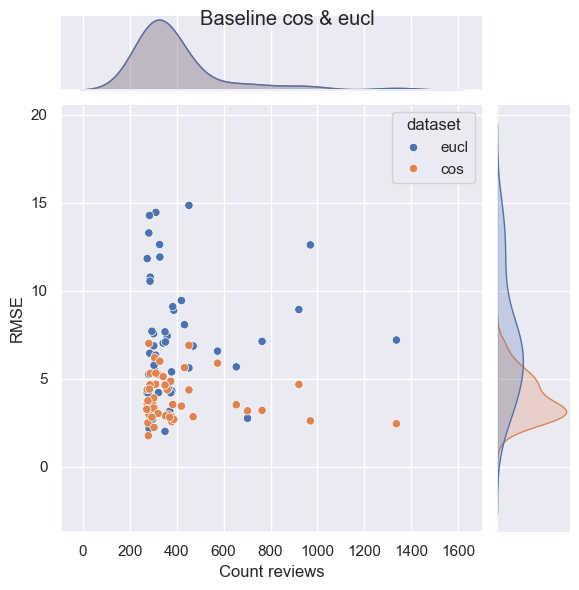

In [14]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
n_ticks = 5  
ax = sns.jointplot(x='Count reviews', y='RMSE', data=df_all_rmse, hue="dataset")

ax.figure.suptitle("Baseline cos & eucl")